In [53]:
! pip install torchgan
# Imports
import keras
import random
import numpy as np
import matplotlib.pyplot as plt

# Pytorch and Torchvision Imports
import torch
import torch.nn as nn
import torchvision
from torch.optim import Adam
import torch.nn as nn
import torch.utils.data as data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchgan.metrics import *

# Torchgan Imports
import torchgan
from torchgan.models import *
from torchgan.losses import *
from torchgan.trainer import Trainer


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Loading the MINST dataset

In [9]:
dataset = dsets.MNIST(
    root="./mnist",
    train=True,
    transform=transforms.Compose(
        [
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,), std=(0.5,)),
        ]
    ),
    download=True,
)
dataloader = data.DataLoader(dataset, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



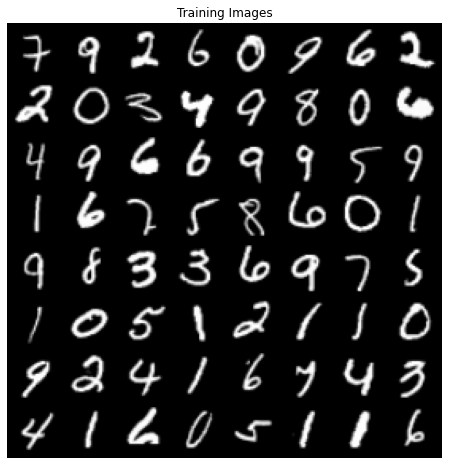

In [10]:
# Plot some of the training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(), (1, 2, 0))
)
plt.show()

## Part 1 - DCGAN Network 

In [11]:
# Setting up the DCGAN model 
dcgan_network = {
    "generator": {
        "name": DCGANGenerator,
        "args": {
            "encoding_dims": 100,
            "out_channels": 1,
            "step_channels": 32,
            "nonlinearity": nn.LeakyReLU(0.2),
            "last_nonlinearity": nn.Tanh(),
        },
        "optimizer": {"name": Adam, "args": {"lr": 0.0001, "betas": (0.5, 0.999)}},
    },
    "discriminator": {
        "name": DCGANDiscriminator,
        "args": {
            "in_channels": 1,
            "step_channels": 32,
            "nonlinearity": nn.LeakyReLU(0.2),
            "last_nonlinearity": nn.LeakyReLU(0.2),
        },
        "optimizer": {"name": Adam, "args": {"lr": 0.0003, "betas": (0.5, 0.999)}},
    },
}

In [12]:
# Defining the loss for DCGAN. The chosen Loss type is leasr square method.
lsgan_losses = [LeastSquaresGeneratorLoss(), LeastSquaresDiscriminatorLoss()]

Training the DCGAN network.

In [54]:
# Training the DCGAN network
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # Use deterministic cudnn algorithms
    torch.backends.cudnn.deterministic = True
    epochs = 10
else:
    device = torch.device("cpu")
    epochs = 5

trainer = Trainer(
    dcgan_network, lsgan_losses, sample_size=64, epochs=epochs, device=device
)

trainer(dataloader)


Saving Model at './model/gan0.model'
Epoch 1 Summary
Epoch time duration : 27.172694206237793
generator Mean Gradients : 3.959669142473118
discriminator Mean Gradients : 18.7312591496988
Mean Running Discriminator Loss : 0.03770883106338635
Mean Running Generator Loss : 0.5734416161264692
Generating and Saving Images to ./images/epoch1_generator.png



/usr/local/lib/python3.8/dist-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


Saving Model at './model/gan1.model'
Epoch 2 Summary
Epoch time duration : 28.573189973831177
generator Mean Gradients : 3.371461153325577
discriminator Mean Gradients : 31.707138651537534
Mean Running Discriminator Loss : 0.040983678201145964
Mean Running Generator Loss : 0.5287335440198749
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
Epoch time duration : 30.30130672454834
generator Mean Gradients : 3.292189614143391
discriminator Mean Gradients : 29.833682496881742
Mean Running Discriminator Loss : 0.03557187667452116
Mean Running Generator Loss : 0.5171556587846633
Generating and Saving Images to ./images/epoch3_generator.png

Saving Model at './model/gan3.model'
Epoch 4 Summary
Epoch time duration : 26.25508189201355
generator Mean Gradients : 3.3454248801303756
discriminator Mean Gradients : 27.570257797994604
Mean Running Discriminator Loss : 0.031722978687659505
Mean Running Generator Loss : 0.51268798877387

The above one is run for 10 epochs which was better than 5 epochs. The accuracy for 5 epochs was around 50 which is lesser than 10 epochs. The accuracy might increase if epochs are increased further but it proves to be a computaionally expenseive task without GPU. 

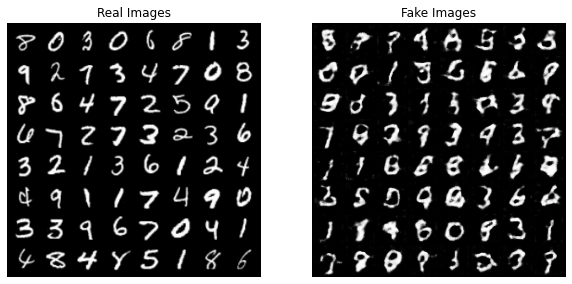

In [55]:
# Visual comparison of the real and the fake images. 

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))
device = torch.device("cuda:0")
# Plot the real images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1, 2, 0),))

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, trainer.epochs)))
plt.show()

Accuracy of our trained DCGAN network

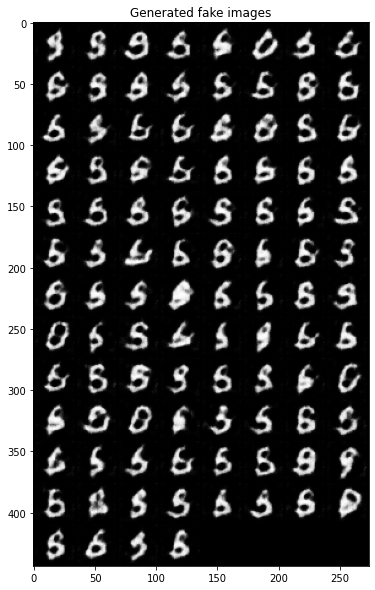

Accuracy of the model on fake images =  1.0


In [56]:
# Accuracy of Descriminator on fake images 
# Generate 100 fake images for testing model accuracy

# Randomly initialize the 100 images
x = torch.rand(size=(10,100,10), device=device)

# Pass the images to the generator to generate the random images
out_gen = trainer.generator.forward(x)

# Plot the random images generated
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(vutils.make_grid(out_gen.to(device), padding=2, normalize=True).cpu(),(1, 2, 0),))
plt.title("Generated fake images")
plt.show()

# Get the discriminator prediction of these images 
out_disc = trainer.discriminator.forward(out_gen)

# Compute accuracy based on these predictions
out_disc_np = out_disc.cpu().detach().numpy()
condition = out_disc_np < 0.5
accuracy = np.extract(condition, out_disc_np)
accuracy_fake = accuracy.size/100.0
print("Accuracy of the model on fake images = " ,  accuracy_fake)


0 [-0.6591995358467102, -1.1705065965652466, 0.6421377658843994, 0.7925841212272644, -0.5941098928451538, 0.6215864419937134, 0.7492020130157471, -0.9826032519340515, 0.2941192090511322, 1.4972302913665771, 0.42478975653648376, -1.1160650253295898, -2.677424907684326, 0.13102476298809052, 0.2816281318664551, -0.7199668884277344, 0.21106089651584625, 0.4584454596042633, 0.6365767121315002, -0.30170291662216187, 1.5135036706924438, 2.1262049674987793, 0.14288124442100525, -0.12533168494701385, -0.7691813707351685, -1.129408597946167, -0.15770365297794342, -1.152976393699646, 1.139711856842041, 1.1504069566726685, 0.902443528175354, -0.6384419798851013, -2.6168599128723145, -0.17135176062583923, -0.17355801165103912, 0.6995406150817871, -0.08060514181852341, 0.4880020320415497, 0.34589025378227234, 0.0016135623445734382, 1.1640625, -1.099947214126587, 0.20488634705543518, 0.9844304323196411, -2.1522817611694336, 0.9713627099990845, -0.7834547758102417, 0.6404166221618652, -0.5072095394134

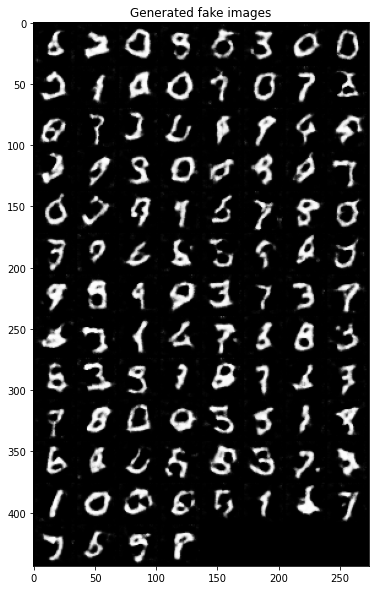

In [65]:
for i,p in enumerate(x):
  v=[]
  for pt in p:
    v.append(pt.item())
  print(i,v)
out_gen = trainer.generator.forward(x)

# Plot the random images generated
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(vutils.make_grid(out_gen.to(device), padding=2, normalize=True).cpu(),(1, 2, 0),))
plt.title("Generated fake images")
plt.show()

In [72]:
imgs = {
    '0' : [0.5367206335067749, -0.34860727190971375, 0.07398941367864609, -2.1566319465637207, 2.31160569190979, 1.882730484008789, 0.34484267234802246, 1.535875916481018, -0.4685406982898712, -0.4904087483882904, 0.028583059087395668, -0.21095944941043854, -1.4257313013076782, 0.47763872146606445, -0.12144986540079117, 2.820603847503662, -0.16918034851551056, -0.5456475615501404, 0.3620895743370056, -0.05440334230661392, -0.21336261928081512, -1.1869169473648071, -1.1361504793167114, -0.3185705840587616, -1.9802899360656738, -0.6232404112815857, -0.17118240892887115, 0.49080654978752136, 0.1392245590686798, -1.0902092456817627, 0.5978792905807495, 0.23787285387516022, 1.2325384616851807, -1.6381893157958984, -0.029665064066648483, -1.402458667755127, -2.0043723583221436, 1.4302797317504883, 0.29801473021507263, 0.11240879446268082, 0.9332586526870728, 1.075933575630188, 0.9632775187492371, 0.14926551282405853, -1.2864429950714111, -0.8472367525100708, -1.7198902368545532, 1.2764263153076172, 0.27996543049812317, -0.8869746923446655, 0.8323323130607605, -0.5074945688247681, 1.70699942111969, 0.9019104242324829, 0.9401201605796814, 0.31663113832473755, 1.9299002885818481, -0.45533815026283264, -1.4401930570602417, 0.7415568232536316, -0.6149731278419495, -0.7262346744537354, -1.092816948890686, 0.9279956221580505, 0.13105015456676483, 2.0375022888183594, -0.3479457199573517, 1.1192266941070557, -1.4792166948318481, -0.5389841794967651, -0.32916268706321716, 0.44768667221069336, 0.025735411792993546, -1.230992078781128, -1.605849027633667, -1.7917194366455078, 0.9601090550422668, -0.30670270323753357, 0.14127756655216217, -1.138048768043518, -0.6764851212501526, 0.3981672525405884, 0.287088006734848, -0.15932951867580414, -1.1515374183654785, -0.1711161732673645, -0.76729816198349, 0.05448117107152939, -0.9513296484947205, 1.5183688402175903, 0.5653397440910339, 0.14808323979377747, 0.42660489678382874, 0.5140582919120789, 0.22010523080825806, -2.2135372161865234, 1.6480680704116821, -1.3290754556655884, 0.6927156448364258, -1.2649617195129395],
    '1' : [0.5086788535118103, 3.0742430686950684, -0.6841875314712524, -0.7739363312721252, -0.08833272010087967, -0.3902168273925781, 2.3368782997131348, -2.174267292022705, -2.3029592037200928, -0.06769341975450516, -2.4739561080932617, -0.18792422115802765, -0.3104303479194641, -0.7138899564743042, 0.3879324793815613, -0.35779789090156555, -0.6940895318984985, -1.0138863325119019, -0.2942078113555908, 1.6172035932540894, -0.05270801857113838, -0.7328441739082336, 1.421035647392273, -1.1411432027816772, -0.443019837141037, -0.02259940654039383, -0.5520743131637573, 0.2501758635044098, 0.9964390397071838, 1.149193286895752, -1.095113754272461, 1.032122015953064, 0.17868289351463318, -0.10209780931472778, -0.3049759268760681, 0.07490012049674988, 0.5516167283058167, -0.8160818219184875, -0.4935789108276367, 2.2072744369506836, 1.1019971370697021, -0.5265501737594604, -1.5459593534469604, -1.0683624744415283, 0.6599148511886597, 0.13679300248622894, 0.6965068578720093, 0.26202458143234253, 0.2776643633842468, 0.8504791855812073, -0.11686623096466064, -1.3205599784851074, -1.3720531463623047, 0.5370810627937317, -1.0766483545303345, 0.08023719489574432, 0.4452810287475586, 0.698341965675354, -1.4654080867767334, -0.5832026600837708, -2.3038089275360107, 0.2961639165878296, 0.8530192375183105, -0.4723157286643982, 1.213211178779602, -0.7245250940322876, 0.8134185671806335,  0.7616143822669983, -0.9620314836502075, 0.10071790963411331, -0.22583676874637604, 0.357194185256958, -0.07418566942214966, -0.1384817361831665, 1.1477200984954834, 1.6109613180160522, 0.1357102394104004, -1.6042773723602295, 0.061191096901893616, -1.658686637878418, -0.5933273434638977, -0.16638489067554474, 0.36274272203445435, -1.1476999521255493, 0.8286229372024536, 1.6407722234725952, 1.7468994855880737, 1.8177679777145386, -2.358832359313965, 0.34003400802612305, 0.21803507208824158, -0.6240112781524658, -0.13908635079860687, 0.3893061578273773, -0.9338887929916382, 0.020414629951119423, -0.6177393794059753, 2.1904683113098145, 2.8927507400512695, -1.5746498107910156],
    '2' : [2.9147768020629883, 1.7378085851669312, -0.16763444244861603, -0.30159446597099304, 0.28154557943344116, 1.4669779539108276, 0.8225955963134766, 0.541653037071228, -1.1299084424972534, -1.7855807542800903, -0.46770334243774414, 1.3271526098251343, -0.37412893772125244, -1.0161601305007935, 1.6799935102462769, 0.7832643389701843, 0.3709962069988251, 0.37756970524787903, 1.747996211051941, -0.9262444376945496, -1.4145739078521729, -1.4990530014038086, -0.7755133509635925, 0.3204082250595093, 1.7290246486663818, -0.7816793918609619, -1.3916265964508057, 0.4368246793746948, 1.2502681016921997, 2.0828964710235596, -0.5196225047111511, 1.2895212173461914, 1.4004302024841309, -1.1263811588287354, 0.8186773061752319, -0.45852717757225037, -1.3988420963287354, 0.1020825058221817, 0.8150193095207214, -1.2028015851974487, 2.457974433898926, -2.3209288120269775, -0.914161205291748, -0.49709779024124146, -0.4195285141468048, 0.7451750040054321, -0.41113996505737305, 1.3786128759384155, 1.31207275390625, 1.3519827127456665, -0.5365199446678162, -2.055976390838623, -0.5817291736602783, 0.3474173843860626, -0.25327515602111816, -0.6013248562812805, 1.4452519416809082, -0.19327674806118011, 0.18998032808303833, -0.8356368541717529, 0.7378855347633362, -0.8892325758934021, -0.09511177241802216, -1.4783085584640503, -0.49309369921684265, -1.0920212268829346, 1.0704660415649414, -0.591224193572998, -0.28990405797958374, 1.083550214767456, 0.6241941452026367, 0.43363484740257263, 1.9145501852035522, -1.3976138830184937, 1.008156180381775, -1.1014689207077026, 0.8117925524711609, -1.4585281610488892, 0.10654761642217636, -0.7303571701049805, -0.4392794072628021, -0.3625717759132385, -0.02016771212220192, 0.8437454104423523, -0.6031991243362427, 0.33593156933784485, 1.3573827743530273, 1.4117339849472046, 0.575864851474762, -1.2375242710113525, -1.0040582418441772, 0.6015976667404175, -0.10240872949361801, -0.806279718875885, -0.7321523427963257, 0.7441544532775879, -0.20692342519760132, -0.7120678424835205, -0.6705151200294495, 0.13603712618350983],
    '3' : [-2.6861283779144287, 0.4217093586921692, 0.3956744968891144, 0.39738526940345764, -0.1465149074792862, 0.34644371271133423, -0.7557835578918457, 0.15884430706501007, -0.09352494776248932, -0.8833443522453308, 0.25039011240005493, -0.5622133612632751, -0.2942914366722107, 0.20607976615428925, -0.2272973507642746, 2.427967071533203, -1.0455281734466553, 1.241416096687317, 1.0702582597732544, 0.5294492244720459, 0.4148200452327728, 1.021846055984497, -2.2279648780822754, -0.051511675119400024, 0.1812244951725006, 0.36777108907699585, -0.9650141000747681, -0.9856904745101929, -0.2879070043563843, -0.950093150138855, 0.47814127802848816, -1.3222347497940063, -0.9773344993591309, 0.6746072173118591, -0.9965652227401733, -0.4869377017021179, 0.1765981763601303, 0.8141629695892334, 0.3761742413043976, 0.43533971905708313, -1.066504716873169, 1.0266423225402832, 0.333782821893692, -0.5761851668357849, -0.39108705520629883, -0.3521531820297241, -1.0279697179794312, 0.8632583618164062, 0.5491089820861816, -1.272027850151062, -0.5372025966644287, 0.11506219208240509, -1.9816392660140991, 1.4501272439956665, -1.274466872215271, -0.4653131663799286, -1.370760440826416, 0.1957504153251648, 0.09131047129631042, -1.6274266242980957, -0.5332719683647156, 0.041637785732746124, 0.8165255188941956, 0.2282218039035797, -1.0882800817489624, -0.36354345083236694, -1.5444244146347046, 0.783322811126709, -1.0645538568496704, 0.7110286951065063, -0.03183586522936821, 1.2875524759292603, -0.06569088995456696, 0.394031822681427, 0.5824215412139893, -2.0697858333587646, 0.8643117547035217, -1.9719176292419434, -0.767017662525177, -0.0809691771864891, -0.359462171792984, -0.5196568965911865, -0.49594131112098694, 0.35501667857170105, -1.0634698867797852, 0.4700775742530823, 0.5480464696884155, -0.4856259822845459, -1.2073322534561157, -0.6980818510055542, 0.9342738389968872, 0.8700895309448242, -1.2140319347381592, 1.2748093605041504, -0.6986872553825378, 0.06048912554979324, 0.6342733502388, -0.9725741147994995, 0.5694831609725952, 0.7119041085243225],
    '4' : [0.848396897315979, -0.2835291624069214, -0.9236103892326355, -2.378821849822998, -1.0954772233963013, 0.22092898190021515, 0.5723150372505188, 0.7263572216033936, -1.0340489149093628, 0.3171910345554352, -0.5297589302062988, 0.1669817566871643, 0.15873382985591888, 0.33310335874557495, 0.2988668978214264, -1.2034194469451904, 0.4439586102962494, 0.3360595703125, -1.244616985321045, 1.3226637840270996, -0.8593912124633789, -0.6932640671730042, 0.7416788935661316, 0.17319296300411224, 0.5986793637275696, 0.7393944263458252, 0.36683085560798645, 1.155985951423645, 0.3865595757961273, 0.3299761414527893, -1.446649193763733, -0.513645350933075, 0.4985627830028534, 1.279827356338501, -1.3141298294067383, 0.9863327741622925, -1.074062705039978, 1.6258282661437988, -0.6267046332359314, -0.12890613079071045, 0.4804303050041199, 0.34476327896118164, -0.676045835018158, -0.2646710276603699, -0.041822727769613266, -0.6182587742805481, 1.1417794227600098, 0.12021616101264954, 0.4882439076900482, -0.7130231857299805, -0.9062218070030212, 1.205535650253296, -0.8385459184646606, -0.38205987215042114, 1.4390239715576172, 0.9547674655914307, 2.002963066101074, 1.0936399698257446, 0.545799732208252, 0.9286397099494934, 0.17747490108013153, -1.726035475730896, 0.8293592929840088, 0.4636242389678955, 0.6255646347999573, 0.5587213039398193, -1.057446837425232, -0.16425721347332, 0.7449241876602173, -0.10731664299964905, -1.066881775856018, 0.009036692790687084, -0.7831745743751526, -0.04796035960316658, -0.4036056399345398, 0.18426825106143951, -0.04000841826200485, -0.08466359972953796, 1.4620506763458252, 1.8951970338821411, -0.39459049701690674, -0.7854610085487366, -0.6219787001609802, -1.035454511642456, -0.7194207310676575, -0.2300412952899933, 1.0056579113006592, 1.169925570487976, 1.360142707824707, -0.03277614340186119, 1.0671684741973877, 0.14407183229923248, 1.0553237199783325, -0.6853988766670227, -0.506120502948761, 2.5769546031951904, -2.0704426765441895, 1.6373810768127441, 0.714504063129425, 0.5447370409965515],
    '5' : [-0.5463249087333679, 1.31722891330719, -0.20163415372371674, -0.9463473558425903, -1.8734403848648071, 0.4899360239505768, -0.32427123188972473, -0.022863760590553284, 0.24612681567668915, -0.9373283982276917, -0.00663971109315753, -0.6470808386802673, 0.7078279256820679, -2.293872594833374, -1.1855052709579468, -1.4549055099487305, -0.4100453853607178, -1.6846694946289062, 0.2609412372112274, 0.2721579670906067, -1.003848671913147, 0.4364771246910095, -0.4510992467403412, -0.30064889788627625, -1.2604703903198242, -0.9993607401847839, 2.1126840114593506, 0.08992770314216614, -0.768250584602356, 0.9938169121742249, 0.8567326068878174, 0.5041617155075073, -0.9801618456840515, -0.23521074652671814, -1.9024653434753418, 1.5469179153442383, 0.9308465123176575, 1.0032192468643188, 0.4798722565174103, 0.43209385871887207, -1.0630189180374146, -0.6998264193534851, -1.0308541059494019, 0.6651068925857544, 1.3292185068130493, 1.7661395072937012, 0.2984861731529236, -0.17625759541988373, -0.2508757710456848, -0.8758764266967773, -0.3738398551940918, -1.1715437173843384, 1.7029837369918823, 1.634846568107605, -0.48620107769966125, -1.4193947315216064, -0.4441339075565338, -1.0676732063293457, -0.308789998292923, -1.1211291551589966, 0.05527433753013611, -0.2869923710823059, 0.4095281958580017, 0.5225351452827454, -0.2042083591222763, -1.517245888710022, 1.5638011693954468, 1.402474284172058, -0.6200697422027588, -0.5938347578048706, -0.6462348699569702, 1.1033989191055298, 0.1773330420255661, -0.09651847183704376, 1.183679461479187, 0.10398358106613159, -0.29676583409309387, -0.8938636779785156, 1.3410723209381104, 0.33159253001213074, -1.040976643562317, -0.6886811852455139, 0.9642009139060974, -0.10449476540088654, -0.11996597796678543, 0.1786244660615921, 0.9444907903671265, -0.24286039173603058, 1.7646957635879517, -1.1559165716171265, 1.1516469717025757, 1.2928740978240967, 1.31783127784729, -0.14832818508148193, 0.7554885745048523, -0.3820788562297821, 0.9746319651603699, 1.231432318687439, 0.6351699233055115, -1.5807807445526123],
    '6' : [-0.2111343890428543, -0.7478868365287781, -0.15965093672275543, 0.9878000020980835, 0.2805810570716858, 0.27668002247810364, -0.9218597412109375, 0.328276664018631, 0.8871550559997559, -0.6166514158248901, 1.0042977333068848, -1.644943118095398, -0.3950982987880707, 0.5861161947250366, -1.4188724756240845, 0.194109708070755, 1.026232361793518, -1.155694842338562, -0.08132688701152802, -0.9971445202827454, -0.6580008864402771, -2.339364767074585, 0.9990177154541016, -2.026040554046631, 0.42340177297592163, -0.7253978252410889, 0.22015708684921265, 0.6676309108734131, -1.105294942855835, 0.45475977659225464, 1.3899190425872803, -0.013230269774794579, -0.22566862404346466, -0.2695682942867279, -0.46776261925697327, 0.48997995257377625, -0.47391557693481445, -1.907873272895813, 1.0655266046524048, 0.7517315149307251, -1.0260459184646606, 0.6244814991950989, 0.5246787071228027, 1.381034255027771, 0.29719847440719604, -0.8514015674591064, 0.7875851988792419, 0.2072860449552536, -1.1069459915161133, 0.5128803849220276, 0.32887348532676697, -1.0021387338638306, 0.7636162638664246, -0.2229185253381729, -0.38064396381378174, -1.6242644786834717, 0.2976749539375305, -0.8444684147834778, 2.8480172157287598, 0.32187893986701965, 1.5259641408920288, -0.4741954803466797, 1.8425359725952148, 0.19246023893356323, -0.465573787689209, 1.5729236602783203, 0.08831916004419327, 1.0409306287765503, -0.002835808787494898, 2.0285003185272217, -0.3539453148841858, -0.004634236916899681, 1.4043359756469727, 1.0683399438858032, 1.863649845123291, 0.5545535087585449, -0.6484431624412537, -1.0291916131973267, -0.8096712231636047, -0.996870756149292, -0.16962963342666626, -0.324309378862381, -0.09137154370546341, -0.8286128640174866, 1.6500266790390015, -1.3932088613510132, 0.6439734697341919, -0.01436181552708149, 1.0427030324935913, 0.8907232284545898, 1.404389500617981, 0.6477615237236023, -1.346462368965149, 1.086176872253418, 0.5456367135047913, -0.8133643865585327, 0.014278803020715714, -0.5389918684959412, 1.2247401475906372, 1.1391524076461792],
    '7' : [0.33972203731536865, 1.8849055767059326, 0.19782131910324097, 0.6441733837127686, -0.8053550720214844, -1.8520406484603882, 0.2875005006790161, -0.3041123151779175, 0.37406548857688904, -0.5346227884292603, -0.9976276159286499, 0.7912358045578003, -0.38800767064094543, 0.021894026547670364, -1.8127819299697876, 2.4353432655334473, 0.3962611258029938, 2.160982370376587, -1.5757490396499634, -0.2684187591075897, -0.8603511452674866, -2.2313249111175537, 0.7940175533294678, -0.06791172176599503, -1.01985502243042, 0.051665037870407104, 0.08488903194665909, 1.0946992635726929, 0.24612528085708618, 1.92530357837677, -0.24964070320129395, 2.015078067779541, -0.5901290774345398, -0.17757588624954224, -0.05594861879944801, -0.14996188879013062, -0.368233859539032, -0.6976708769798279, -0.48676997423171997, -0.3337066173553467, -0.8659316897392273, -0.42999327182769775, 1.209112286567688, 2.610215187072754, -0.512523353099823, -0.9690282344818115, 1.0905317068099976, -1.2516320943832397, -0.9767322540283203, 0.2954336404800415, -0.20177771151065826, 1.2967305183410645, -0.2082894742488861, 0.8310357928276062, 1.0914710760116577, 0.7285845279693604, -1.0667461156845093, -1.3439668416976929, 1.2937366962432861, 0.3306366205215454, 0.8551191091537476, 0.40121763944625854, 0.8666641116142273, -1.040791630744934, -0.2288007289171219, -2.0373380184173584, -1.3012231588363647, -1.5298103094100952, 0.32619136571884155, -0.07000010460615158, -0.11024721711874008, -0.13550136983394623, 1.865397334098816, -0.7580636739730835, 0.9448472261428833, 0.5828332304954529, -0.9633612632751465, 0.8224102854728699, 0.8501983284950256, -0.5806319713592529, 0.5585514307022095, -0.37327826023101807, 2.303711414337158, -1.1292505264282227, -0.11819379031658173, -1.8467639684677124, 1.2917935848236084, 0.6191386580467224, -1.9598041772842407, 0.5965765118598938, -1.6939523220062256, 0.4681646227836609, -0.766711950302124, -0.15530475974082947, -1.0107595920562744, 0.0675191879272461, -0.4918183982372284, 0.7772512435913086, 0.2753172218799591, 0.08646469563245773],
    '8' : [2.0170795917510986, 1.580767273902893, -0.05703193321824074, 0.3171527683734894, 0.40196454524993896, -1.1412631273269653, 0.63918137550354, 0.8385621309280396, 1.064534068107605, 2.206476926803589, -0.5588210225105286, 0.8508692383766174, 0.35970211029052734, -1.847031593322754, 0.09721657633781433, 0.7874470353126526, 0.44924795627593994, -0.49044156074523926, -1.2882059812545776, -0.8614007234573364, 0.8026125431060791, -0.2816888093948364, 0.2842055857181549, 0.6550419926643372, 0.22106239199638367, 0.5053588151931763, -0.4321631193161011, 0.15937381982803345, 0.6713283061981201, -0.1259896606206894, -0.3884873390197754, 1.1673024892807007, 1.6222264766693115, -0.7794458270072937, -0.3282349109649658, -1.636969804763794, -0.8724133372306824, 0.42812880873680115, -2.1267049312591553, 0.002384464954957366, -1.2715884447097778, -1.2605961561203003, 0.12572209537029266, 0.3837077021598816, -0.892988383769989, 0.4151652455329895, -0.688066840171814, 0.3426467776298523, 0.3489127457141876, -0.12283118814229965, 0.25785714387893677, -0.48521462082862854, 1.2843819856643677, 1.740112543106079, 0.23266944289207458, -1.0751378536224365, 0.12320570647716522, 0.5850684642791748, 1.6662873029708862, 0.204852893948555, 0.8205264806747437, 1.090656042098999, 1.738221526145935, 2.2408766746520996, 2.0926530361175537, -0.08126938343048096, 0.3264462947845459, 0.05172303691506386, -0.07574287801980972, 0.19880090653896332, 1.271451473236084, 1.3570784330368042, 0.2787863612174988, -0.4120735824108124, 0.5403793454170227, 0.6070826649665833, 0.047834623605012894, 0.4120512306690216, 0.9898595809936523, -1.291566252708435, 0.4576958417892456, -1.21675443649292, 1.6547476053237915, -0.08371641486883163, 2.3569986820220947, 0.33285191655158997, 2.7720961570739746, 0.9260523915290833, 2.8438363075256348, -0.051956258714199066, -0.22221088409423828, 0.7393970489501953, -0.7285960912704468, 0.075063556432724, -0.31332358717918396, -0.4785168170928955, 0.10821093618869781, 1.258440613746643, 0.21090976893901825, -0.49254125356674194],
    '9' : [-0.14772196114063263, -0.6068382859230042, 0.5567882657051086, 2.5415520668029785, 0.11810888350009918, -0.32783955335617065, 0.35823604464530945, -1.6206653118133545, -0.6218726634979248, 0.200964093208313, -0.0176454596221447, -0.6179150938987732, 0.8880777359008789, -0.17973273992538452, 0.26209840178489685, -0.018252111971378326, -0.38622620701789856, -0.21158692240715027, 0.07762590050697327, -2.14396071434021, -1.097232460975647, 1.0853017568588257, -1.1021848917007446, -0.5775961875915527, -1.781853199005127, 1.9458298683166504, -1.4294111728668213, 2.4614858627319336, -1.2444530725479126, 1.2955560684204102, 1.117196798324585, 1.7512993812561035, -0.4689861238002777, -0.45256373286247253, 0.5925634503364563, 1.08179771900177, -0.5079745054244995, 2.1292171478271484, 0.9750493764877319, 0.9800869226455688, 0.7035962343215942, 1.2304755449295044, -1.3873636722564697, -0.7573587894439697, 1.1352686882019043, -0.3676966428756714, -0.5666970610618591, 0.6102060675621033, -1.501629114151001, 1.216765284538269, 2.4826390743255615, 1.8203928470611572, 0.735483705997467, -0.6634439826011658, -0.8326278924942017, -1.2020727396011353, -1.0683274269104004, -1.5714280605316162, 1.101815104484558, -0.0938926413655281, 0.2558480501174927, -0.36174145340919495, 1.6073522567749023, -0.7630755305290222, -1.5470380783081055, -0.8584014773368835, 0.8550466895103455, -0.1828436702489853, -0.3346521854400635, 0.8644744753837585, -1.8043054342269897, -0.03319442644715309, -0.14171014726161957, -0.16212350130081177, -0.1785421371459961, 0.5006394386291504, 0.5905510783195496, 0.7289684414863586, -1.0242347717285156, -1.4379864931106567, -1.1134852170944214, -0.7702745199203491, -0.9452475309371948, -0.513243556022644, 0.314863383769989, 0.8380221724510193, 1.7205941677093506, -0.16525579988956451, 0.17288286983966827, -1.1551061868667603, -0.922016441822052, 0.7993504405021667, 1.0154937505722046, 1.3324602842330933, 0.13325312733650208, -0.39258289337158203, -0.5410158038139343, -0.4578281342983246, -0.14954863488674164, -0.2706374526023865]

       }

<ipython-input-73-0dd8e918df9b>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  i_p = torch.FloatTensor(ten).to(device)


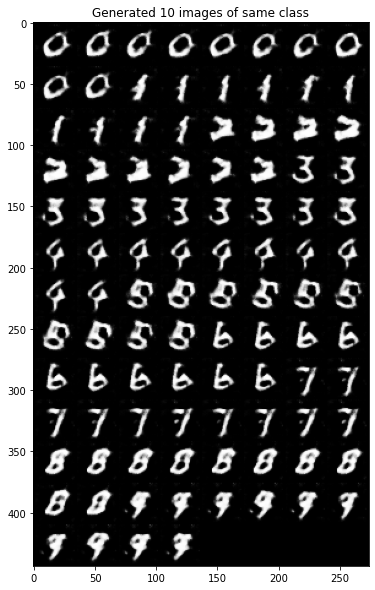

In [73]:
ten = []
num_dim =100

for i in imgs:
  for j in range(10):
    ten.append(np.array(imgs[i] + np.random.normal(0, 0.18, num_dim)))

i_p = torch.FloatTensor(ten).to(device)
o_p = trainer.generator.forward(i_p)

# Plot the random images generated
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(vutils.make_grid(o_p.to(device), padding=2, normalize=True).cpu(),(1, 2, 0),))
plt.title("Generated 10 images of same class")
plt.show()

In [60]:
#Testing accuracy of benign inputs by choosing random samples from the actual dataset

i = 0
# Load batches of 64 images 100 times to get accuracy
correct_detection = 0 
while (i<100):
  real_batch = next(iter(dataloader))
  out_disc = trainer.discriminator.forward(real_batch[0].to(torch.device("cuda:0")))
  out_disc_np = out_disc.cpu().detach().numpy()
  condition = out_disc_np > 0.5
  accuracy = np.extract(condition, out_disc_np)
  #print(accuracy.size)
  #print(accuracy.size)
  correct_detection = correct_detection + accuracy.size/64.0
  i = i+1
accuracy_benign = correct_detection/100
print ("Accuracy of Descriminator on benign samples = " , accuracy_benign)

Accuracy of Descriminator on benign samples =  0.0428125


In [58]:
# Total accuracy of the discriminator 

total_accuracy = (accuracy_benign+accuracy_fake)/2.0
print ("Accuracy of the Discriminator = ", total_accuracy)

Accuracy of the Discriminator =  0.52453125


One can infer that even though the accuracy is high on fake images, when it comes to beningn images, the accuracy drops very low. Hence this brings down the accuracy of the model. If we see the generated fake images, though they seem to be proper numbers, it doesn't contain all the classes or numbers (0-9). Therefore the generated numbers are biased (this is probably because the some numbers like 7 and 9 have similar distributions). This seems to be a drawback of DCGAN. 

In [59]:
# Computing the accuracy of Generator.
# Accuracy of the generator is computed using Inspection score which is a score of how accurately can human eyes identify the images as real.

acc_generator = torchgan.metrics.ClassifierScore()
acc_generator.classifier=trainer.generator
score = acc_generator.calculate_score(out_gen)
print("Inspector score for DCGAN: " , score)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inspector score for DCGAN:  tensor(1., device='cuda:0')


## Part 2 - CGAN Network 

In [22]:
# Setting up the CGAN model 
cgan_network = {
    "generator": {
        "name": ConditionalGANGenerator,
        "args": {
            "encoding_dims": 100,
            "num_classes": 10,  # MNIST digits range from 0 to 9
            "out_channels": 1,
            "step_channels": 32,
            "nonlinearity": nn.LeakyReLU(0.2),
            "last_nonlinearity": nn.Tanh(),
        },
        "optimizer": {"name": Adam, "args": {"lr": 0.0001, "betas": (0.5, 0.999)}},
    },
    "discriminator": {
        "name": ConditionalGANDiscriminator,
        "args": {
            "num_classes": 10,
            "in_channels": 1,
            "step_channels": 32,
            "nonlinearity": nn.LeakyReLU(0.2),
            "last_nonlinearity": nn.Tanh(),
        },
        "optimizer": {"name": Adam, "args": {"lr": 0.0003, "betas": (0.5, 0.999)}},
    },
}


Training the CGAN network.

In [28]:
# Training the CGAN network
trainer_cgan = Trainer(
    cgan_network, lsgan_losses, sample_size=64, epochs=epochs, device=device
)

trainer_cgan(dataloader)

Saving Model at './model/gan0.model'
Epoch 1 Summary
Epoch time duration : 30.337916612625122
generator Mean Gradients : 3.5123618854224827
discriminator Mean Gradients : 11.211902797717382
Mean Running Discriminator Loss : 0.039008638219359806
Mean Running Generator Loss : 0.5034508716974304
Generating and Saving Images to ./images/epoch1_generator.png



/usr/local/lib/python3.8/dist-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


Saving Model at './model/gan1.model'
Epoch 2 Summary
Epoch time duration : 29.96273446083069
generator Mean Gradients : 2.03675153886871
discriminator Mean Gradients : 7.669353130432776
Mean Running Discriminator Loss : 0.024527697074999
Mean Running Generator Loss : 0.506178491885887
Generating and Saving Images to ./images/epoch2_generator.png

Saving Model at './model/gan2.model'
Epoch 3 Summary
Epoch time duration : 29.99856472015381
generator Mean Gradients : 2.2071700922447843
discriminator Mean Gradients : 10.256059897763693
Mean Running Discriminator Loss : 0.06208252132819454
Mean Running Generator Loss : 0.46107142230372694
Generating and Saving Images to ./images/epoch3_generator.png

Saving Model at './model/gan3.model'
Epoch 4 Summary
Epoch time duration : 29.985630989074707
generator Mean Gradients : 2.4467476286175307
discriminator Mean Gradients : 11.876101783058289
Mean Running Discriminator Loss : 0.07656072822366797
Mean Running Generator Loss : 0.4342232374792128
Ge

In [41]:
ax = [0.039008638219359806,0.024527697074999,0.06208252132819454,  0.07656072822366797,0.08306588289908258, 0.0881353767351312, 0.09154615525505257,0.0935493076708311, 0.09364707367921916, 0.09266960312274031 ]
ay = [0.5034508716974304, 0.506178491885887, 0.46107142230372694,0.4342232374792128,0.4225555936569598,0.41336297548317114, 0.4070953968810238,0.40303517300744796,0.4023562545683592,0.4039871369701014]

Text(0, 0.5, 'Loss')

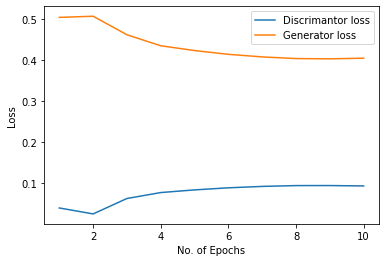

In [52]:
xx = [1,2,3,4,5,6,7,8,9,10]
plt.plot(xx,ax,label='Discrimantor loss')
plt.plot(xx,ay,label='Generator loss')
plt.legend()
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
#plt.legend('Discrimantor loss')

The common GAN loss function is min max equation where it tries to minimize the Generator loss and simulataneously maximise the Discriminator loss. This is what is happening in the above figure as we can see the number of epochs increase, one is decreasing and the other is increasing. 

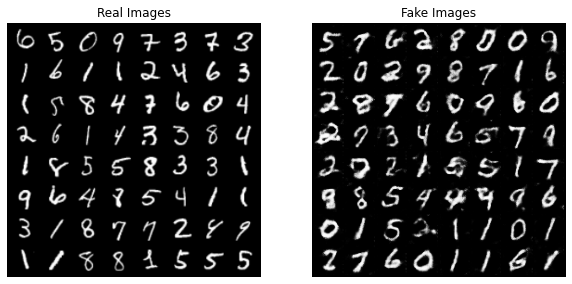

In [29]:
# Visual comparison of the real and the fake images.
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))
# Plot the real images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1, 2, 0),))

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(plt.imread("{}/epoch{}_generator.png".format(trainer.recon, trainer.epochs)))
plt.show()

Accuracy of our trained CGAN network

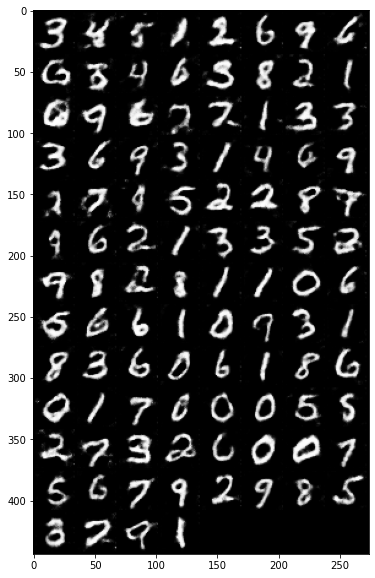

Accuracy of the model on fake images =  0.35


In [64]:
# Accuracy of Descriminator on fake images 
# Generate 100 fake images for testing model accuracy
noise_dim = 100
# Randomly initialize the 100 images
x= torch.FloatTensor(np.random.normal(0,1,(100,noise_dim))).to(device)
## 100 samples
## clasases 0-9
y=np.zeros(100)
for i in range(100):
  y[i]=random.randint(0,9)

## have to convert type from ndarray to tensors to work with torch
y= torch.FloatTensor(y).to(device)
#print(y)
# Pass the images to the generator to generate the random images
out_gen = trainer_cgan.generator.forward(x, y)

# Plot the random images generated
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(vutils.make_grid(out_gen.to(device), padding=2, normalize=True).cpu(),(1, 2, 0),))
plt.show()


# Get the discriminator prediction of these images 
out_disc = trainer_cgan.discriminator.forward(out_gen, y)

# Compute accuracy based on these predictions
out_disc_np = out_disc.cpu().detach().numpy()
condition = out_disc_np < 0.5
accuracy = np.extract(condition, out_disc_np)
accuracy_fake = accuracy.size/100.0
print("Accuracy of the model on fake images = " ,  accuracy_fake)

In [38]:
#Testing accuracy of benign inputs by choosing random samples from the actual dataset

i = 0
# Load batches of 64 images 100 times to get accuracy
correct_detection = 0 
while (i<100):
  real_batch = next(iter(dataloader))
  out_disc = trainer_cgan.discriminator.forward(real_batch[0].to(device), real_batch[1].to(device))
  out_disc_np = out_disc.cpu().detach().numpy()
  condition = out_disc_np > 0.5
  accuracy = np.extract(condition, out_disc_np)
  correct_detection = correct_detection + accuracy.size/64.0
  i = i+1
accuracy_benign = correct_detection/100
print ("Accuracy of Descriminator on benign samples = " , accuracy_benign)

Accuracy of Descriminator on benign samples =  0.9934375


In [39]:
# Total accuracy of the discriminator 

total_accuracy = (accuracy_benign+accuracy_fake)/2.0
print ("Accuracy of the Discriminator = ", total_accuracy)

Accuracy of the Discriminator =  0.6717187499999999


There has been a increase in accuracy. The reason could be the passing of the labels Y which was not being done in DCGAN. We see that when we passed the generated label too, we are now able to get almost all the classes compared to the previous one where the generated images were biased towards particular classes. This drawback of DCGAN is overcome by DCGAN. 

In [40]:
# Computing the accuracy of Generator.
# Accuracy of the generator is computed using Inspection score which is a score of how accurately can human eyes identify the images as real.

acc_generator = torchgan.metrics.ClassifierScore()
acc_generator.classifier=trainer_cgan.generator

score = acc_generator.calculate_score(out_gen)
print("Inspector score for DCGAN: " , score)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inspector score for DCGAN:  tensor(1., device='cuda:0')
